In [60]:
import pandas as pd

# Load CSV
df = pd.read_csv("newspaper_concat.csv", sep=";")
df["year"] = df["publication_date"].astype(str).str[:4]
year_counts = df["year"].value_counts().sort_index()


In [ ]:
df.columns

Index(['Unnamed: 0', 'page_id', 'pagenumber', 'paper_title', 'provider_ddb_id',
       'provider', 'zdb_id', 'publication_date', 'place_of_distribution',
       'language', 'thumbnail', 'pagefulltext', 'pagename',
       'preview_reference', 'plainpagefulltext', 'year'],
      dtype='object')

In [ ]:
df.paper_title.value_counts()

paper_title
Kölnische Zeitung. 1803-1945                                                                                                                                              1453
Neues Tagblatt und General-Anzeiger für Stuttgart und Württemberg                                                                                                         1409
Hamburger Fremdenblatt                                                                                                                                                    1272
Schwäbischer Merkur : mit Schwäbischer Kronik und Handelszeitung : Süddeutsche Zeitung                                                                                    1221
General-Anzeiger. 1889-1945                                                                                                                                               1066
                                                                                                                 

In [ ]:
df["year_num"] = df.year.apply(lambda s: int(s))
df.year_num.sort_values().value_counts().sort_index()

year_num
1860     1
1861     1
1863     1
1866     2
1871     1
        ..
1943    28
1944     9
1950     2
1952     1
1955     1
Name: count, Length: 77, dtype: int64

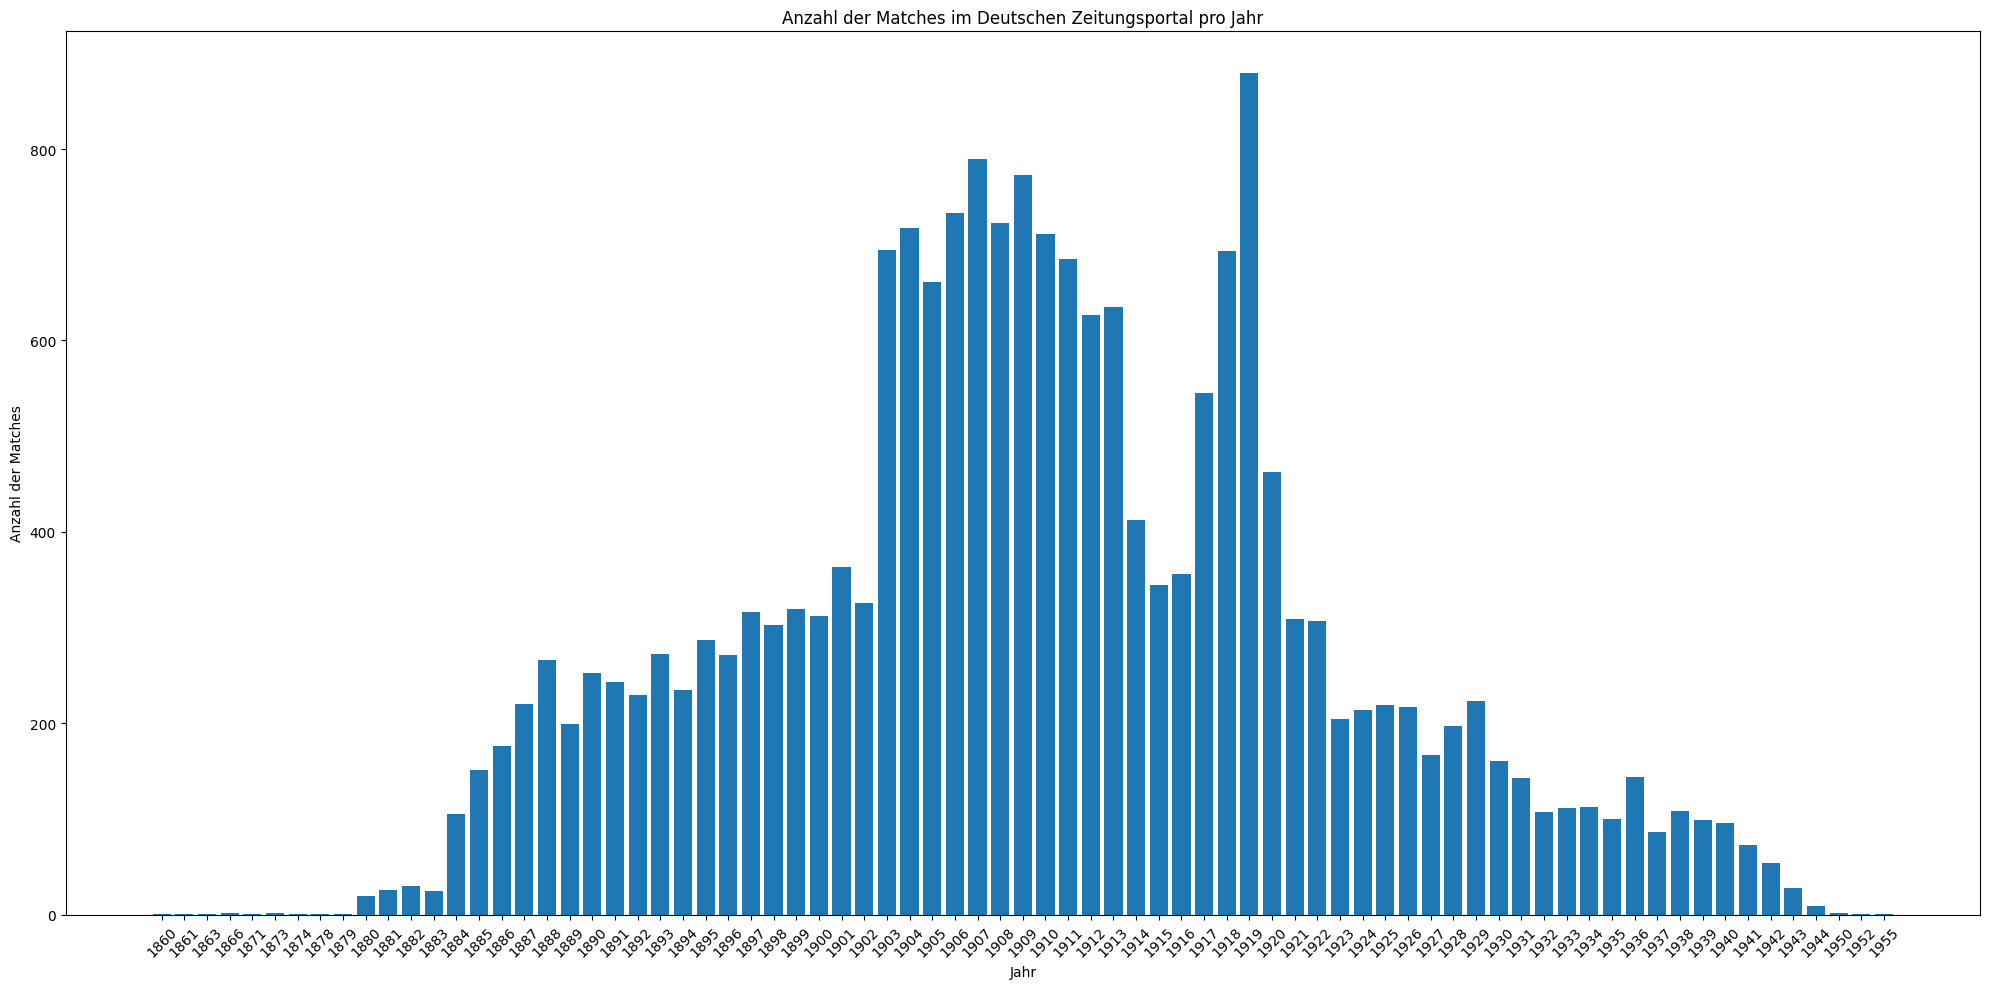

In [63]:
import matplotlib.pyplot as plt


# Plot
plt.figure(figsize=(20, 10))
plt.bar(year_counts.index, year_counts.values)

# Enhance readability
plt.xlabel("Jahr")
plt.ylabel("Anzahl der Matches")
plt.title("Anzahl der Matches im Deutschen Zeitungsportal pro Jahr")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("articles_per_year.png", dpi=300, bbox_inches='tight')
plt.show()


In [64]:
def remove_one_character_tokens(text: str) -> str:
    text_list = text.split(" ")
    text_list_clean = [w for w in text_list if len(w) > 1]
    clean_string = " ".join(text_list_clean)
    return clean_string

df["cleaned_text"] = df.plainpagefulltext.apply(lambda s: remove_one_character_tokens(s))
clean = df.cleaned_text.head(20)
original = df.plainpagefulltext.head(20)

pd.concat([clean, original], axis=1)


,cleaned_text,plainpagefulltext
0,Ausland Brüssel 22 Juni Die Regierung hat wie ...,"Ausland . Brüssel , 22 . Juni . Die Regierung ..."
1,von in auf hatte un 1ng Nir püecher Pecan da f...,von in auf # # # hatte un 1ng Nir # püecher 8 ...
2,Grostölustraße 63 Grostälnstraße 63 Manufaktur...,M Grostölustraße : : 63 . : Grostälnstraße ! 6...
3,Lokales Nachen den 24 August 1922 Im Regenscha...,"K Lokales . Nachen , den 24 . August 1922 . Im..."
4,für ein Aute im Zeuikum der Stadt gesucht 9794...,für ein Aute im Zeuikum der Stadt gesucht . 97...
5,Technis zu Aachen mit angelehnter Handelshochs...,Technis zu Aachen mit angelehnter Handelshochs...
6,Der Homitber der Eine Märzskizze aus der Vogel...,Der Homitber der Eine Märzskizze aus der Vogel...
7,Stadttheater Aachen Concordia Direktion Hofrat...,"Stadttheater Aachen , Concordia , Direktion : ..."
8,Auch Sie müssen einen Führerschein haben Rufen...,Auch Sie müssen einen Führerschein haben Rufen...
9,sillie des sor Dr Ehrendienst entgegengeich em...,sillie des . # # sor Dr . Ehrendienst entgegen...


In [126]:
import google.generativeai as genai
from config_file import configs
import ast
from random import randint

def get_gemini_text_extraction(input_text: str, page_id: str) -> list:
    API_KEY = configs["API_KEY"]
    genai.configure(api_key=API_KEY)

    generation_config = {
        "temperature": 1,
        "top_p": 0.95,
        "top_k": 40,
        "max_output_tokens": 8192,
        "response_mime_type": "text/plain",
    }

    model = genai.GenerativeModel(
        model_name="gemini-1.5-flash-8b",
        generation_config=generation_config,
    )

    results = []
    prompt = configs["PROMPT"]

    response = model.generate_content([prompt, input_text])
    response = response.text.replace("```python", "").replace("```", "")
    response = ast.literal_eval(response)
    if response is not None or response == []:
        for r in response:
            #results.append((page_id, r))
            results.append(r)
    
    return results

df_generalanzeiger = df[df.paper_title == "General-Anzeiger. 1889-1945"].reset_index()
n = randint(0, len(df_generalanzeiger))
response = get_gemini_text_extraction(df.plainpagefulltext[n], df.page_id[n])
#Cleaning ist nicht immer besser - besser plain text verwenden
#print(f"This is not cleaned: {response} \n This is the cleaned string {response_cleaned_text}")
response

['Selbst. Handw. mit gut. Gesch., 27., kath. u. sp. schönes Vermög. wünscht die Bek. e. verm. Mädchens mit einiger Mille Mitgift. Aussteuer ist vorhand. Mädch., welche sich nach ein zufried. Heim sehnen, wollen ihre gefl. Off. unter N 6946 an die Exped. d. Bl. einsenden.']